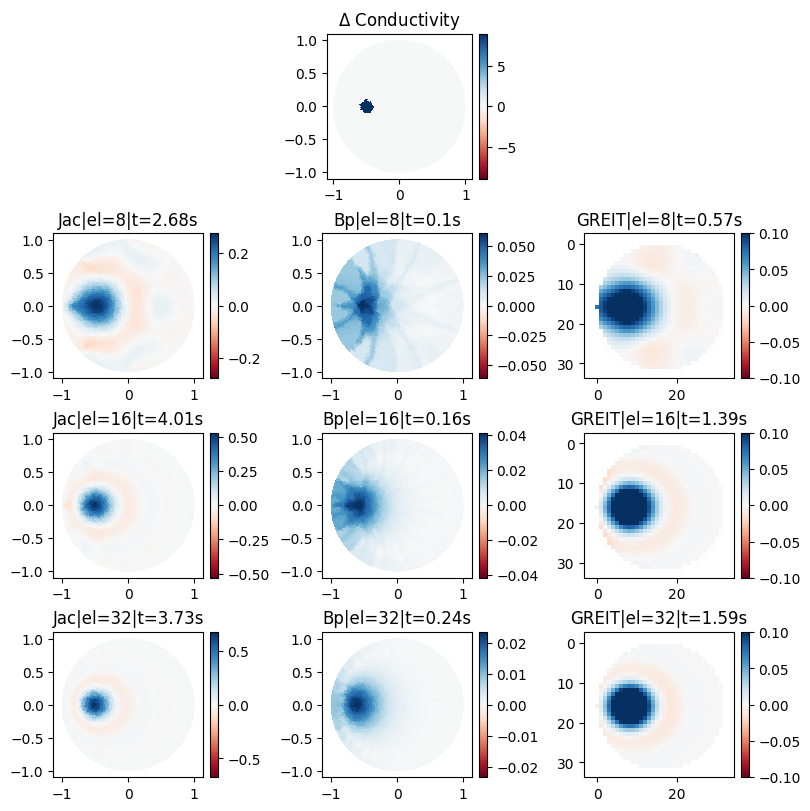

In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.jac as jac
import numpy as np
import pyeit.eit.bp as bp
import pyeit.eit.greit as greit
import pyeit.mesh as mesh
import time
from pyeit.eit.fem import EITForward
from pyeit.eit.interp2d import sim2pts
import pyeit.eit.protocol as protocol
from pyeit.mesh.wrapper import PyEITAnomaly_Circle

mr = 0.04
n_el1 = 8 
n_el2 = 16
n_el3 = 32
anomaly = [
  
    PyEITAnomaly_Circle(center=[-0.5, 0], r=0.1, perm=10.0),
]
""" 0. build mesh """
n_el = n_el1 # nb of electrodes
mesh_obj= mesh.create(n_el, h0=mr)
# extract node, element, alpha
pts = mesh_obj.node
tri = mesh_obj.element
x, y = pts[:, 0], pts[:, 1]

""" 1. problem setup """
mesh_new= mesh.set_perm(mesh_obj, anomaly=anomaly ,background=1.0)
delta_perm = np.real(mesh_new.perm - mesh_obj.perm)


# plot ground truth
pmax = np.max(np.abs(delta_perm))
fig, axes = plt.subplots(4, 3, constrained_layout=True)
fig.set_size_inches(8, 8)

ax = axes[0,1]
ax.set_title(r"$\Delta$ Conductivity")
delta_perm = mesh_new.perm - mesh_obj.perm
im = ax.tripcolor(x, y, tri, np.real(delta_perm), shading="flat", cmap=plt.cm.RdBu,vmin=-pmax,vmax=pmax)
ax.set_aspect("equal")
fig.colorbar(im)


""" 2. FEM simulation """
# setup EIT scan conditions
protocol_obj = protocol.create(n_el, dist_exc=1 , step_meas=1, parser_meas="std")

# calculate simulated data
fwd = EITForward(mesh_obj, protocol_obj)
v0 = fwd.solve_eit()
v1 = fwd.solve_eit(perm=mesh_new.perm)

""" 3.1. JAC solver """
start=time.time()
eit = jac.JAC(mesh_obj, protocol_obj)
eit.setup(p=0.5, lamb=0.01, method="kotre", perm=1, jac_normalized=True)
ds = eit.solve(v1, v0, normalize=True)
ds_n = sim2pts(pts, tri, np.real(ds))
end=time.time()
duration = end-start


# plot EIT reconstruction JAC
jac_max = np.max(np.abs(ds_n))
ax = axes[1,0]
im = ax.tripcolor(x, y, tri, ds_n, shading="flat",cmap=plt.cm.RdBu,vmin=-jac_max,vmax=jac_max)
ax.set_title(f'Jac|el={n_el}|t={round(duration,2)}s')
ax.axis("equal")
fig.colorbar(im)

""" 3.2. naive inverse solver using back-projection """
start=time.time()
eit = bp.BP(mesh_obj, protocol_obj)
eit.setup(weight="none")
# the normalize for BP when dist_exc>4 should always be True
ds = eit.solve(v1, v0, normalize=True)
end=time.time()
duration = end-start

# plot EIT reconstruction Backprojection
bp_max = np.max(np.abs(ds))
ax = axes[1,1]
im = ax.tripcolor(pts[:, 0], pts[:, 1], tri, ds,cmap=plt.cm.RdBu,vmin=-bp_max,vmax=bp_max)
ax.set_title(f'Bp|el={n_el}|t={round(duration,2)}s')
ax.axis("equal")
fig.colorbar(im)


""" 3.3. Construct using GREIT """
start=time.time()
eit = greit.GREIT(mesh_obj, protocol_obj)
eit.setup(p=0.50, lamb=0.01, perm=1, jac_normalized=True)
ds = eit.solve(v1, v0, normalize=True)
end=time.time()
duration = end-start
x, y, ds = eit.mask_value(ds, mask_value=np.NAN)

# plot EIT reconstruction GREIT
gr_max = np.max(np.abs(ds))
ax = axes[1,2]
im = ax.imshow(np.real(ds), interpolation="nearest",
    cmap=plt.cm.RdBu,
    vmin=-gr_max,
    vmax=gr_max)
ax.set_title(f'GREIT|el={n_el}|t={round(duration,2)}s')
ax.axis("equal")
fig.colorbar(im)






""" 0. build mesh """
n_el = n_el2  # nb of electrodes
mesh_obj= mesh.create(n_el, h0=mr)
# extract node, element, alpha
pts = mesh_obj.node
tri = mesh_obj.element
x, y = pts[:, 0], pts[:, 1]

""" 1. problem setup """
mesh_new= mesh.set_perm(mesh_obj, anomaly=anomaly,background=1.0)


""" 2. FEM simulation """
# setup EIT scan conditions
protocol_obj = protocol.create(n_el, dist_exc=1, step_meas=1, parser_meas="std")

# calculate simulated data
fwd = EITForward(mesh_obj, protocol_obj)
v0 = fwd.solve_eit()
v1 = fwd.solve_eit(perm=mesh_new.perm)

""" 3.1. JAC solver """
start=time.time()
eit = jac.JAC(mesh_obj, protocol_obj)
eit.setup(p=0.5, lamb=0.01, method="kotre", perm=1, jac_normalized=True)
ds = eit.solve(v1, v0, normalize=True)
ds_n = sim2pts(pts, tri, np.real(ds))
end=time.time()
duration = end-start


# plot EIT reconstruction JAC
jac_max = np.max(np.abs(ds_n))
ax = axes[2,0]
im = ax.tripcolor(x, y, tri, ds_n, shading="flat",cmap=plt.cm.RdBu, vmin=-jac_max, vmax=jac_max)
ax.set_title(f'Jac|el={n_el}|t={round(duration,2)}s')
ax.axis("equal")
fig.colorbar(im)

""" 3.2. naive inverse solver using back-projection """
start=time.time()
eit = bp.BP(mesh_obj, protocol_obj)
eit.setup(weight="none")
# the normalize for BP when dist_exc>4 should always be True
ds = eit.solve(v1, v0, normalize=True)
end=time.time()
duration = end-start

# plot EIT reconstruction Backprojection
bp_max = np.max(np.abs(ds))
ax = axes[2,1]
im = ax.tripcolor(pts[:, 0], pts[:, 1], tri, ds,cmap=plt.cm.RdBu,vmin=-bp_max,vmax=bp_max)
ax.set_title(f'Bp|el={n_el}|t={round(duration,2)}s')
ax.axis("equal")
fig.colorbar(im)


""" 3.3. Construct using GREIT """
start=time.time()
eit = greit.GREIT(mesh_obj, protocol_obj)
eit.setup(p=0.50, lamb=0.01, perm=1, jac_normalized=True)
ds = eit.solve(v1, v0, normalize=True)
end=time.time()
duration = end-start
x, y, ds = eit.mask_value(ds, mask_value=np.NAN)

# plot EIT reconstruction GREIT
gr_max = np.max(np.abs(ds))
ax = axes[2,2]
im = ax.imshow(np.real(ds),interpolation="nearest",
    cmap=plt.cm.RdBu,
    vmin=-gr_max,
    vmax=gr_max)
ax.set_title(f'GREIT|el={n_el}|t={round(duration,2)}s')
ax.axis("equal")
fig.colorbar(im)






""" 0. build mesh """
n_el = n_el3  # nb of electrodes
mesh_obj= mesh.create(n_el, h0=mr)
# extract node, element, alpha
pts = mesh_obj.node
tri = mesh_obj.element
x, y = pts[:, 0], pts[:, 1]


""" 1. problem setup """
mesh_new= mesh.set_perm(mesh_obj, anomaly=anomaly,background=1.0)



""" 2. FEM simulation """
# setup EIT scan conditions
protocol_obj = protocol.create(n_el, dist_exc=1 , step_meas=1, parser_meas="std")

# calculate simulated data
fwd = EITForward(mesh_obj, protocol_obj)
v0 = fwd.solve_eit()
v1 = fwd.solve_eit(perm=mesh_new.perm)

""" 3.1. JAC solver """
start=time.time()
eit = jac.JAC(mesh_obj, protocol_obj)
eit.setup(p=0.5, lamb=0.01, method="kotre", perm=1, jac_normalized=True)
ds = eit.solve(v1, v0, normalize=True)
ds_n = sim2pts(pts, tri, np.real(ds))
end=time.time()
duration = end-start


# plot EIT reconstruction JAC
jac_max = np.max(np.abs(ds_n))
ax = axes[3,0]
im = ax.tripcolor(x, y, tri, ds_n, shading="flat", cmap=plt.cm.RdBu, vmin=-jac_max, vmax=jac_max)
ax.set_title(f'Jac|el={n_el}|t={round(duration,2)}s')
ax.axis("equal")
fig.colorbar(im)

""" 3.2. naive inverse solver using back-projection """
start=time.time()
eit = bp.BP(mesh_obj, protocol_obj)
eit.setup(weight="none")
# the normalize for BP when dist_exc>4 should always be True
ds = eit.solve(v1, v0, normalize=True)
end=time.time()
duration = end-start

# plot EIT reconstruction Backprojection
bp_max = np.max(np.abs(ds))
ax = axes[3,1]
im = ax.tripcolor(pts[:, 0], pts[:, 1], tri, ds,cmap=plt.cm.RdBu,vmin=-bp_max,vmax=bp_max)
ax.set_title(f'Bp|el={n_el}|t={round(duration,2)}s')
ax.axis("equal")
fig.colorbar(im)


""" 3.3. Construct using GREIT """
start=time.time()
eit = greit.GREIT(mesh_obj, protocol_obj)
eit.setup(p=0.50, lamb=0.01, perm=1, jac_normalized=True)
ds = eit.solve(v1, v0, normalize=True)
end=time.time()
duration = end-start
x, y, ds = eit.mask_value(ds, mask_value=np.NAN)

# plot EIT reconstruction GREIT
gr_max = np.max(np.abs(ds))
ax = axes[3,2]
im = ax.imshow(np.real(ds),interpolation="nearest",cmap=plt.cm.RdBu,
    vmin=-gr_max,
    vmax=gr_max)
ax.set_title(f'GREIT|el={n_el}|t={round(duration,2)}s')
ax.axis("equal")
fig.colorbar(im)




fig.delaxes(axes[0,0])
fig.delaxes(axes[0,2])
plt.show()

REMARK:
1) Three different image reconstruction methods are shown 
2) The number of electrodes in each row is equal 
3) The image reconstruction method in each colomn is same
 

Result:
1) Jacobian is the slowest and Backprojection is the fastest method
2) GREIT is the trade off between Jacobian and Backprojection for time and resolution